## Benford's law -- Jupyer Notebook using ESRI built-in [Apache Spark](https://spark.apache.org/).

### Apache Spark™ is a unified analytics engine for large-scale data processing.

This notebook is borrowed from Mansour's github [ESRI Spark notebook](https://github.com/mraad/spark-esri) to talk about [**Benford Law**](https://en.wikipedia.org/wiki/Benford%27s_law). When I read his NY Trip duration demonstration, I was very curious and was eager to use a different dataset to see how the result will be. 

I used a Cobb accident report from the year 1980-2018 about half a million records. There are roughly 150,000 valid distance records.Obviously the more data, the more convincing. The data has time stamp and also X,Y coordinate which are certainly not a good choice for first digit. Because they are not natrually occurrences. There is an attribute which shows accident distance to intersection which is a good candidate. Although I did not get perfect Benford curve because of NUMBER 5 does show more of occurences but it is interesting enough to see the kind of MIND BLOWN effect as Mansour did in his notebook.

Create a new conda environment and activate it to use this notebook, as follows:

- Start a `Python Command Prompt` from `Start > ArcGIS`.

- Execute the following:

```
conda create --yes --name spark_esri --clone arcgispro-py3
activate spark_esri
pip install pyarrow
```

### Import the modules.

In [1]:
import os
import arcpy
import numpy as np
import pandas as pd
#import seaborn as sms
import matplotlib.pyplot as plt
from python.sparkInit import spark_start, spark_stop
fc= r'C:\projects\Crash\CobbDatafgdb.gdb\accidentsReports_1'

### Start a Spark instance.

Note the `config` argument to [configure the Spark instance](https://spark.apache.org/docs/latest/configuration.html).

In [2]:
config = {"spark.driver.memory":"2G"}
spark = spark_start(config=config)

### Read the selected accident feature shapes in WebMercator SR.

In [28]:
#fc= r'C:\Users\zhangc\Documents\ArcGIS\Projects\sparkesri\Zone17_2013_09.gdb\Zone17_2013_09_Broadcast'

sp_ref = arcpy.SpatialReference(3857)
data = arcpy.da.SearchCursor(fc,["DISTFROMINTERSECTION","SHAPE@X","SHAPE@Y"],spatial_reference=sp_ref)
#data = arcpy.da.SearchCursor("Broadcast",["SHAPE@X","SHAPE@Y"],spatial_reference=sp_ref)

### Create a Spark data frame of the read data, and create a view named 'v0'.

In [29]:
spark\
    .createDataFrame(data,"distInter long, x double,y double")\
    .createOrReplaceTempView("v0")

In [30]:
pdf = spark.sql(f"""
select distg,count(1) pop
from(
select substr(cast(distInter as string),0,1) distg
from v0
where distInter > 0
)
group by distg
order by distg
""")\
    .toPandas()

c:\program files\arcgis\pro\Java\runtime\spark\python\lib\pyspark.zip\pyspark\sql\dataframe.py:2103: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 0.8.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)


In [31]:
pdf['pct'] = 100.0 * pdf['pop'] / pdf['pop'].sum()

###  Benford values..

In [32]:
benford = 100.0 * np.log10(1.0+1.0/np.arange(1,10,1))

Plot the occurence and the Benford curve.

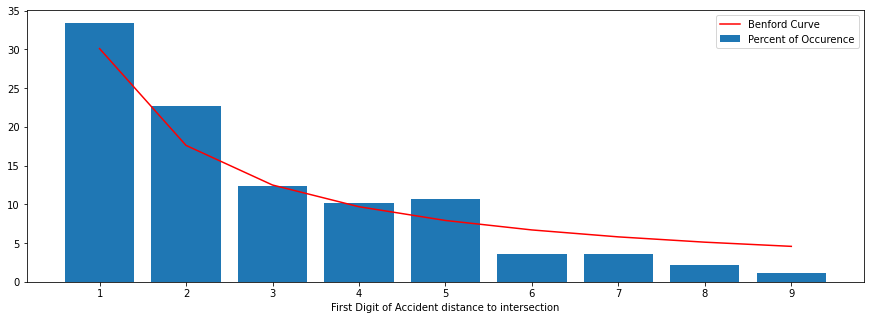

In [36]:
plt.figure(figsize=(15,5))
bar = plt.bar(pdf['distg'],pdf['pct'], label='Percent of Occurence')
plt.plot(pdf['distg'], benford, 'r', label='Benford Curve')
plt.xlabel('First Digit of Accident distance to intersection')
# plt.xticks(rotation=90)
plt.legend()
plt.show()

## Look at the curve! I am kind of WOW##

### Stop the spark instance.

In [34]:
spark_stop()